## Mateusz Strojek, Bartłomiej Sadza

## Projekt końcowy

#### **Zmienna objaśniana**: 
- booking status (czy klient odwołał rezerwację)
#### **Początkowe zmienne objaśniające w zestawie danych**:
- Booking_ID - ID rezerwacji,
- no_of_adults - Liczba dorosłych ujętych w rezerwacji,
- no_of_children - Liczba dzieci ujętych w rezerwacji,
- no_of_weekend_nights - Liczba zarezerwowanych dni weekendowych,
- no_of_week_nights - Liczba zarezerwowanych dni pozaweekendowych,
- type_of_meal_plan - Typ planu jedzeniowego,
- required_car_parking_space - Informacja o tym czy klient potrzebuje miejsca parkingowego,
- room_type_reserved - Typ zarezerwowanego pokoju (brak informacji o tym który droższy, lepszy),
- lead_time - Liczba dni pomiędzy dniem dokonanej rezerwacji i dniem planowanego przyjazdu,
- arrival_year - Rok, w którym klient planuje rozpoczęcie wizyty,
- arrival_month - Miesiąc, w którym klient planuje rozpoczęcie wizyty,
- arrival_date - Dzień miesiąca, w którym klient planuje rozpoczęcie wizyty,
- market_segment_type - W jaki sposób dokonano rezerwacji,
- repeated_guest - Informacja o tym czy klient ponawia swoją wizytę,
- no_of_previous_cancellations - Liczba odwołanych rezerwacji danego klienta,
- no_of_previous_bookings_not_canceled - Liczba nieodwołanych rezerwacji danego klienta,
- avg_price_per_room - Średnia cena pokoju na dzień,
- no_of_special_requests - Liczba specjalnych próśb wysłanych przez klienta.

#### Pobranie bibliotek

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedBaggingClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

pd.set_option('display.max_columns', None)

#### Wstępny ogląd ramki danych

In [299]:
data = pd.read_csv("Hotel Reservations.csv")
data.head()


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


#### Usuwamy zmienną Booking_ID, ponieważ nie przyda się nam przy predykcji oraz zmienną odpowiedzialną za dzień miesiąca.

In [301]:
df = data.copy()
df.drop(columns=["Booking_ID", "arrival_date"], axis=1, inplace=True)

#### Informacja o tym ile brakuje nam wartości dla poszczególnej zmiennej:

In [303]:
print(df.isnull().sum())
df.shape

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64


(36275, 17)

#### Wniosek: Nie posiadamy braków w danych. Mamy więc 18 kolumn i 36275 obserwacji.

#### Zamiana zmiennych na odpowiedni typ:

In [306]:
df["type_of_meal_plan"] = df["type_of_meal_plan"].astype('category')
df["required_car_parking_space"] = df["required_car_parking_space"].astype('category')
df["room_type_reserved"] = df["room_type_reserved"].astype('category')
df["market_segment_type"] = df["market_segment_type"].astype('category')
df["repeated_guest"] = df["repeated_guest"].astype('category')
df["booking_status"] = df["booking_status"].astype('category')

In [307]:
df.dtypes

no_of_adults                               int64
no_of_children                             int64
no_of_weekend_nights                       int64
no_of_week_nights                          int64
type_of_meal_plan                       category
required_car_parking_space              category
room_type_reserved                      category
lead_time                                  int64
arrival_year                               int64
arrival_month                              int64
market_segment_type                     category
repeated_guest                          category
no_of_previous_cancellations               int64
no_of_previous_bookings_not_canceled       int64
avg_price_per_room                       float64
no_of_special_requests                     int64
booking_status                          category
dtype: object

#### Liczba unikalnych wartości dla poszczególnych zmiennych:

In [309]:
df.nunique()

no_of_adults                               5
no_of_children                             6
no_of_weekend_nights                       8
no_of_week_nights                         18
type_of_meal_plan                          4
required_car_parking_space                 2
room_type_reserved                         7
lead_time                                352
arrival_year                               2
arrival_month                             12
market_segment_type                        5
repeated_guest                             2
no_of_previous_cancellations               9
no_of_previous_bookings_not_canceled      59
avg_price_per_room                      3930
no_of_special_requests                     6
booking_status                             2
dtype: int64

#### Wstępna analiza podstawowych statystyk dla zmiennych liczbowych:

In [311]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_adults,36275.0,1.844962,0.518715,0.0,2.0,2.00,2.0,4.0
no_of_children,36275.0,0.105279,0.402648,0.0,0.0,0.00,0.0,10.0
no_of_weekend_nights,36275.0,0.810724,0.870644,0.0,0.0,1.00,2.0,7.0
no_of_week_nights,36275.0,2.204300,1.410905,0.0,1.0,2.00,3.0,17.0
lead_time,36275.0,85.232557,85.930817,0.0,17.0,57.00,126.0,443.0
arrival_year,36275.0,2017.820427,0.383836,2017.0,2018.0,2018.00,2018.0,2018.0
arrival_month,36275.0,7.423653,3.069894,1.0,5.0,8.00,10.0,12.0
no_of_previous_cancellations,36275.0,0.023349,0.368331,0.0,0.0,0.00,0.0,13.0
no_of_previous_bookings_not_canceled,36275.0,0.153411,1.754171,0.0,0.0,0.00,0.0,58.0
avg_price_per_room,36275.0,103.423539,35.089424,0.0,80.3,99.45,120.0,540.0


#### Wniosek: Widać podejrzaną strukturę danych dla zmiennej *no_of_previous_cancellations* ze względu na przeważającą liczbę zer, to samo można powiedzieć o zmiennych *no_of_children* oraz *no_of_previous_cancellations*.

#### Countploty dla zmiennych kategorycznych:

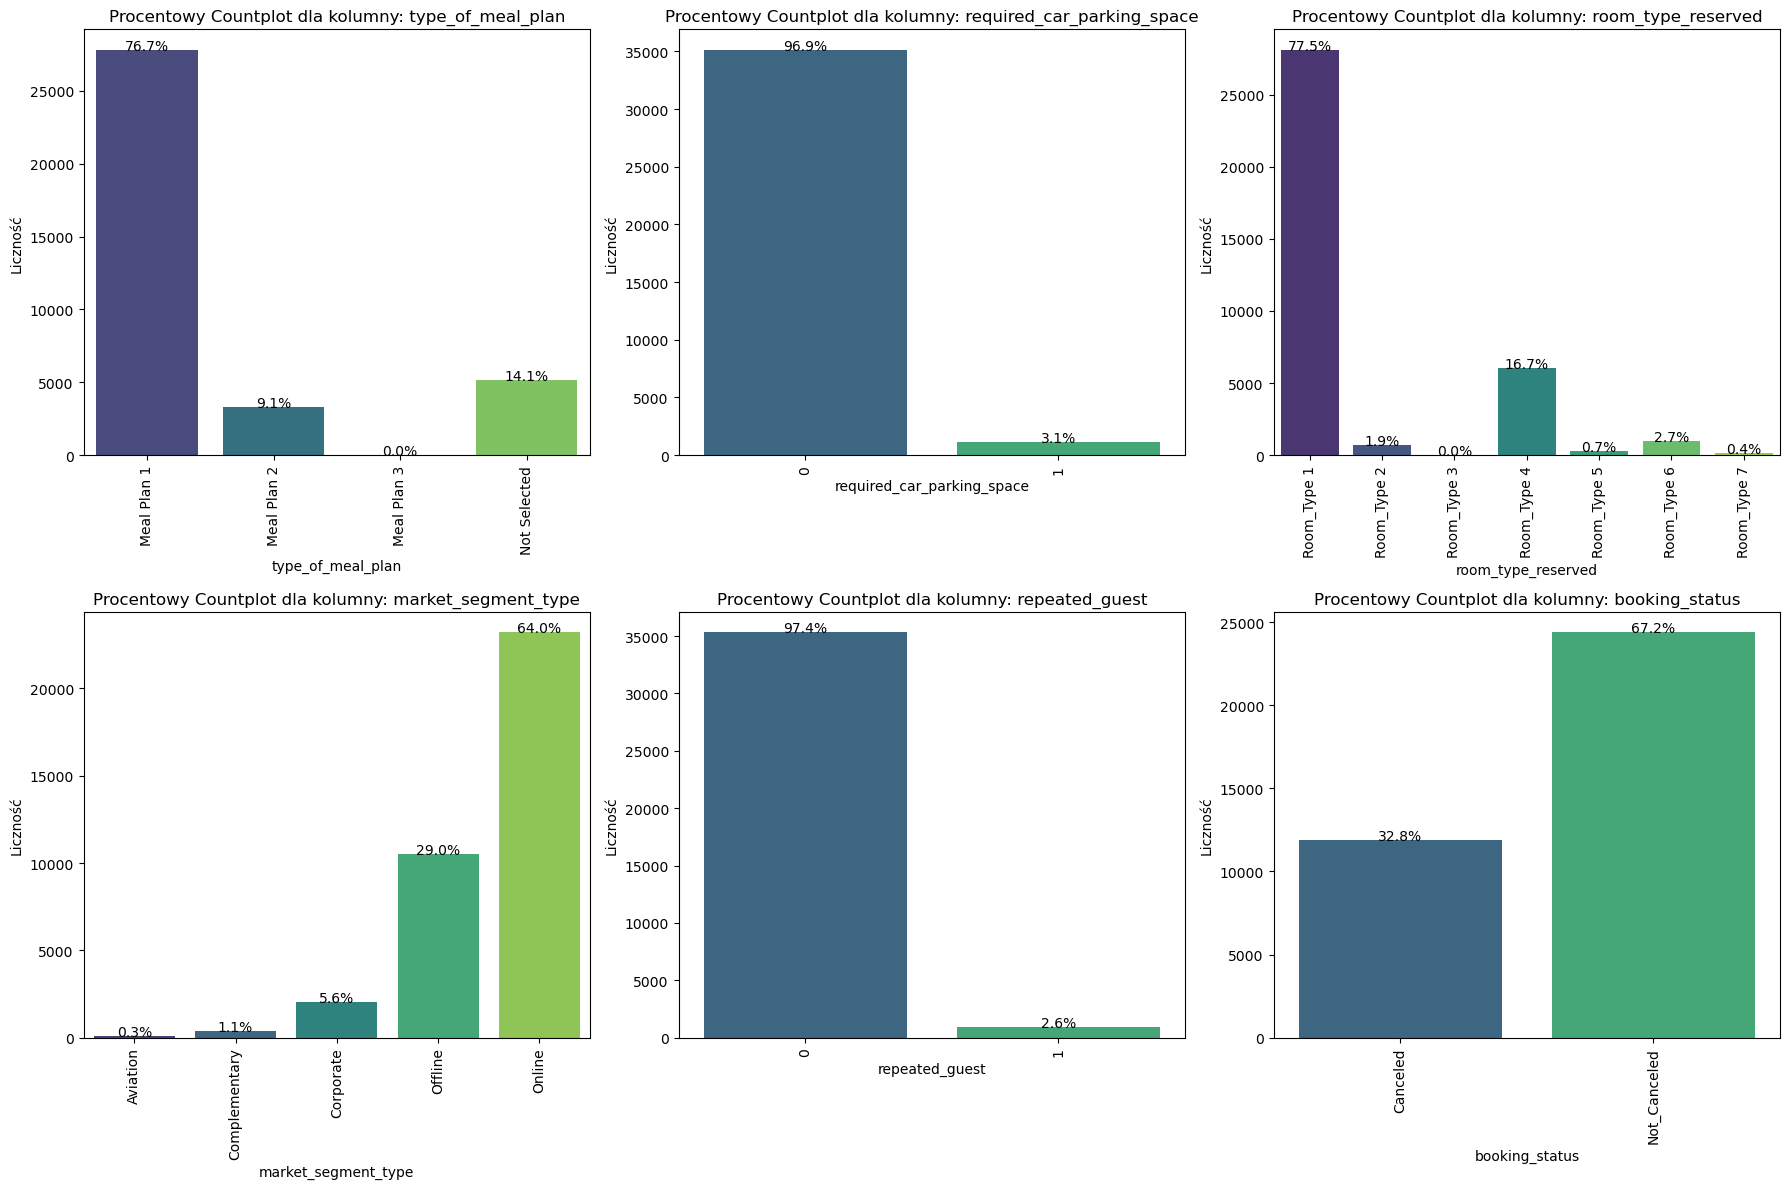

In [314]:
catcols = df.select_dtypes(include='category').columns

plt.figure(figsize=(18, len(catcols)//3 * 6))
rows = 2

for i, column in enumerate(catcols, 1):
    plt.subplot(rows, 3, i) 
    ax = sns.countplot(data=df, x=column, palette="viridis")
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height / len(df) * 100:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='baseline', fontsize=10, color='black')
        ax.tick_params(axis='x' ,rotation=90)
    
    plt.title(f'Procentowy Countplot dla kolumny: {column}')
    plt.ylabel('Liczność')
    plt.xlabel(column)
    
plt.tight_layout()
plt.show()

#### Usuwamy zmienną *required_car_parking_space* oraz *repeated_guest* ze względu na ogromną przewagę w liczebności klasy większościowej (ponad 90%)

In [316]:
df.drop(["required_car_parking_space", "repeated_guest"],axis=1, inplace=True)

#### Pozostałe zmienne:

<Figure size 4000x4000 with 0 Axes>

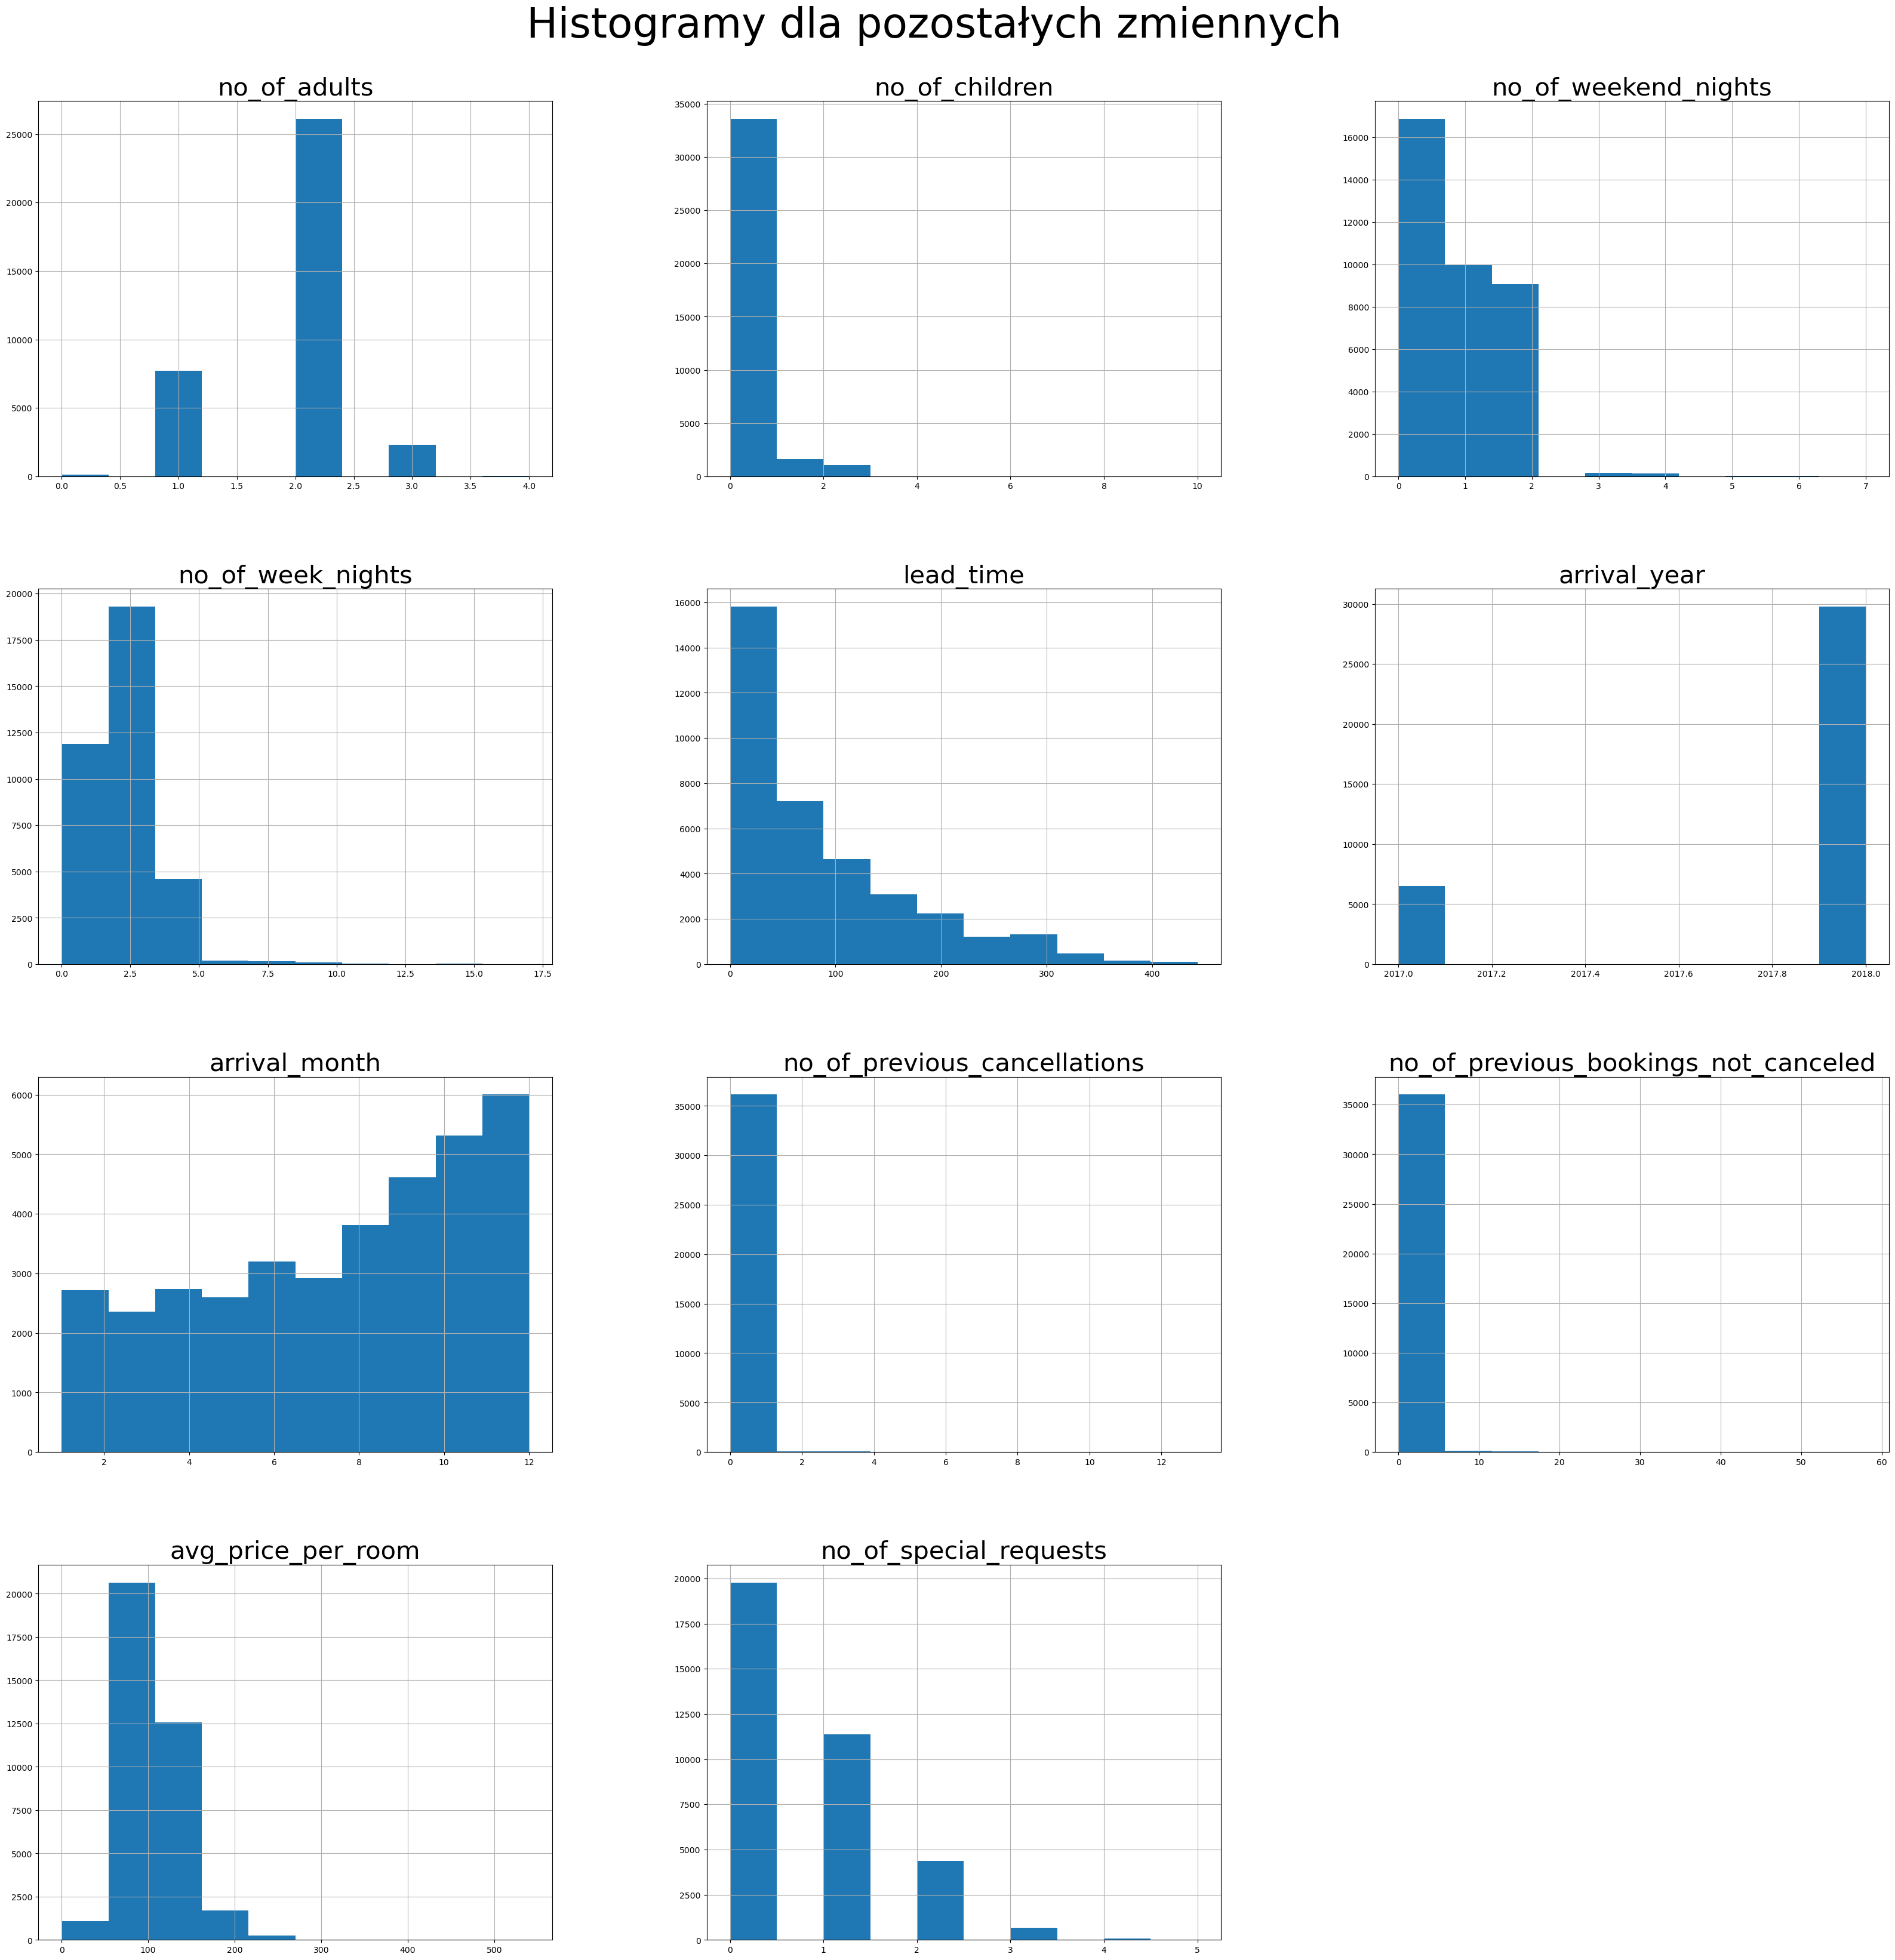

In [318]:
plt.figure(figsize=(40, 40))
axes = df.select_dtypes(include=[int, float]).hist(layout=(4,3), figsize=(40, 40))
for ax in axes.flat:
    ax.set_title(ax.get_title(), fontsize=30)
plt.suptitle("Histogramy dla pozostałych zmiennych", fontsize=50, y=0.92)
plt.show()

#### Usuwamy zmienną *no_of_previous_bookings_not_canceled* oraz *no_of_previous_cancellations* ze względu na występowanie głównie jednej wartości. Przyjrzymy się również zmiennej *no_of_children*.

In [320]:
df.drop(columns=["no_of_previous_cancellations", "no_of_previous_bookings_not_canceled"], axis=1, inplace=True) 
df['no_of_children'].value_counts()/len(df)*100

no_of_children
0     92.562371
1      4.460372
2      2.916609
3      0.052378
9      0.005513
10     0.002757
Name: count, dtype: float64

#### Usuwamy zmienną *no_of_children* ze względu na dużą przewagę rezerwacji, w których nie było dzieci (powyżej 90%)

In [322]:
df.drop(columns=["no_of_children"], axis=1, inplace=True) 

#### Badanie niezbalansowania zmiennej objaśnianej:

<Axes: xlabel='booking_status', ylabel='count'>

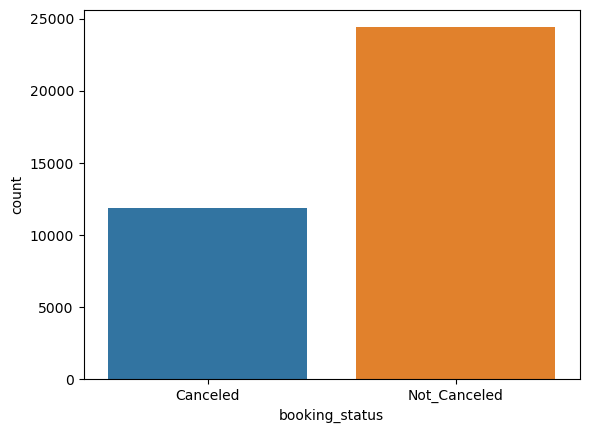

In [324]:
sns.countplot(data=df, x='booking_status')

#### Wniosek: Istnieje potrzeba zastosowania oversamplingu/undersamplingu.

#### Usuwanie wartości odstających:

In [327]:
data = []

for col in df.select_dtypes(include=[int, float]).columns:
    mean = df[col].mean()
    std = df[col].std()
    min_val = df[col].min()
    max_val = df[col].max()
    
    data.append({
        "Column": col,
        "Mean + 3*Std": mean + 3 * std,
        "Mean - 3*Std": mean - 3 * std,
        "Min": min_val,
        "Max": max_val
    })

summary_df = pd.DataFrame(data)
summary_df

,Column,Mean + 3*Std,Mean - 3*Std,Min,Max
0,no_of_adults,3.401107,0.288818,0.0,4.0
1,no_of_weekend_nights,3.422654,-1.801207,0.0,7.0
2,no_of_week_nights,6.437015,-2.028414,0.0,17.0
3,lead_time,343.025007,-172.559893,0.0,443.0
4,arrival_year,2018.971937,2016.668918,2017.0,2018.0
5,arrival_month,16.633336,-1.786031,1.0,12.0
6,avg_price_per_room,208.691811,-1.844733,0.0,540.0
7,no_of_special_requests,2.978363,-1.739052,0.0,5.0


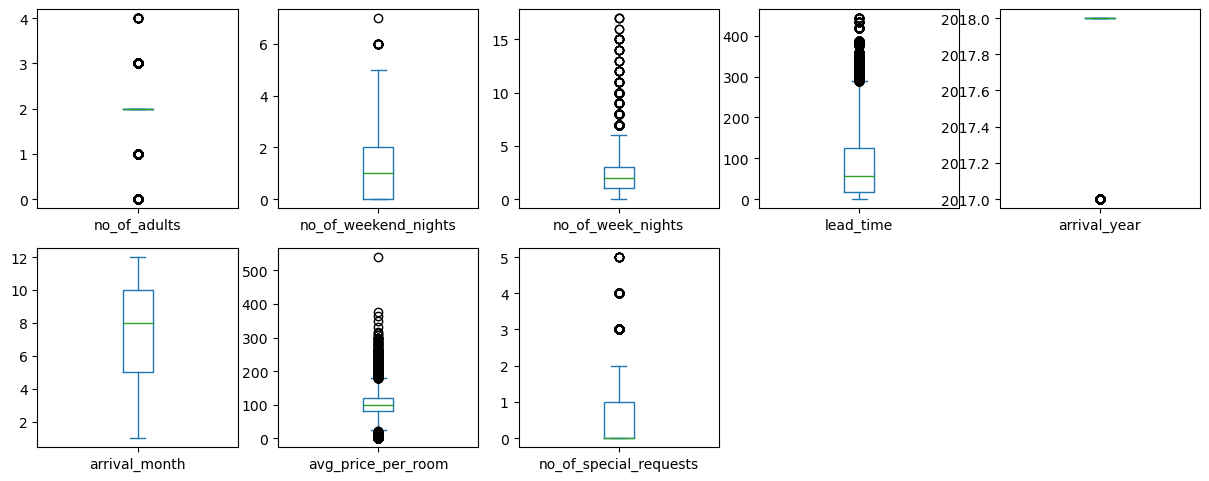

In [328]:
df.plot(kind="box", subplots=True, figsize=(15,15), layout=(5,5))
plt.show()

#### Usuwamy obserwacje, które są spoza zakresu (średnia - 3sd, średnia + 3sd). Wiemy, że nie usunie nam miesięcy i roku na podstawie tabelki powyżej, więc mozna spokojnie to zastosować bez dodatkowej kontroli.

In [330]:
for col in df.select_dtypes(include=[int, float]).columns:
    mean = df[col].mean()
    std = df[col].std()
    df = df[(df[col]<=mean+3*std) & (df[col]>=mean-3*std)]

In [331]:
f"pozostało rekordów: {df.shape[0]}"

'pozostało rekordów: 34308'

#### Sprawdzamy, czy analiza ma jakiś sens - czyli czy rozkład częstotliwości (rozkład gęstości) danej zmiennej jest podobny gdy klient usunął (odbył) rezerwację

##### Wykresy dla zmiennych które można przedstawić na wykresie słupkowym:

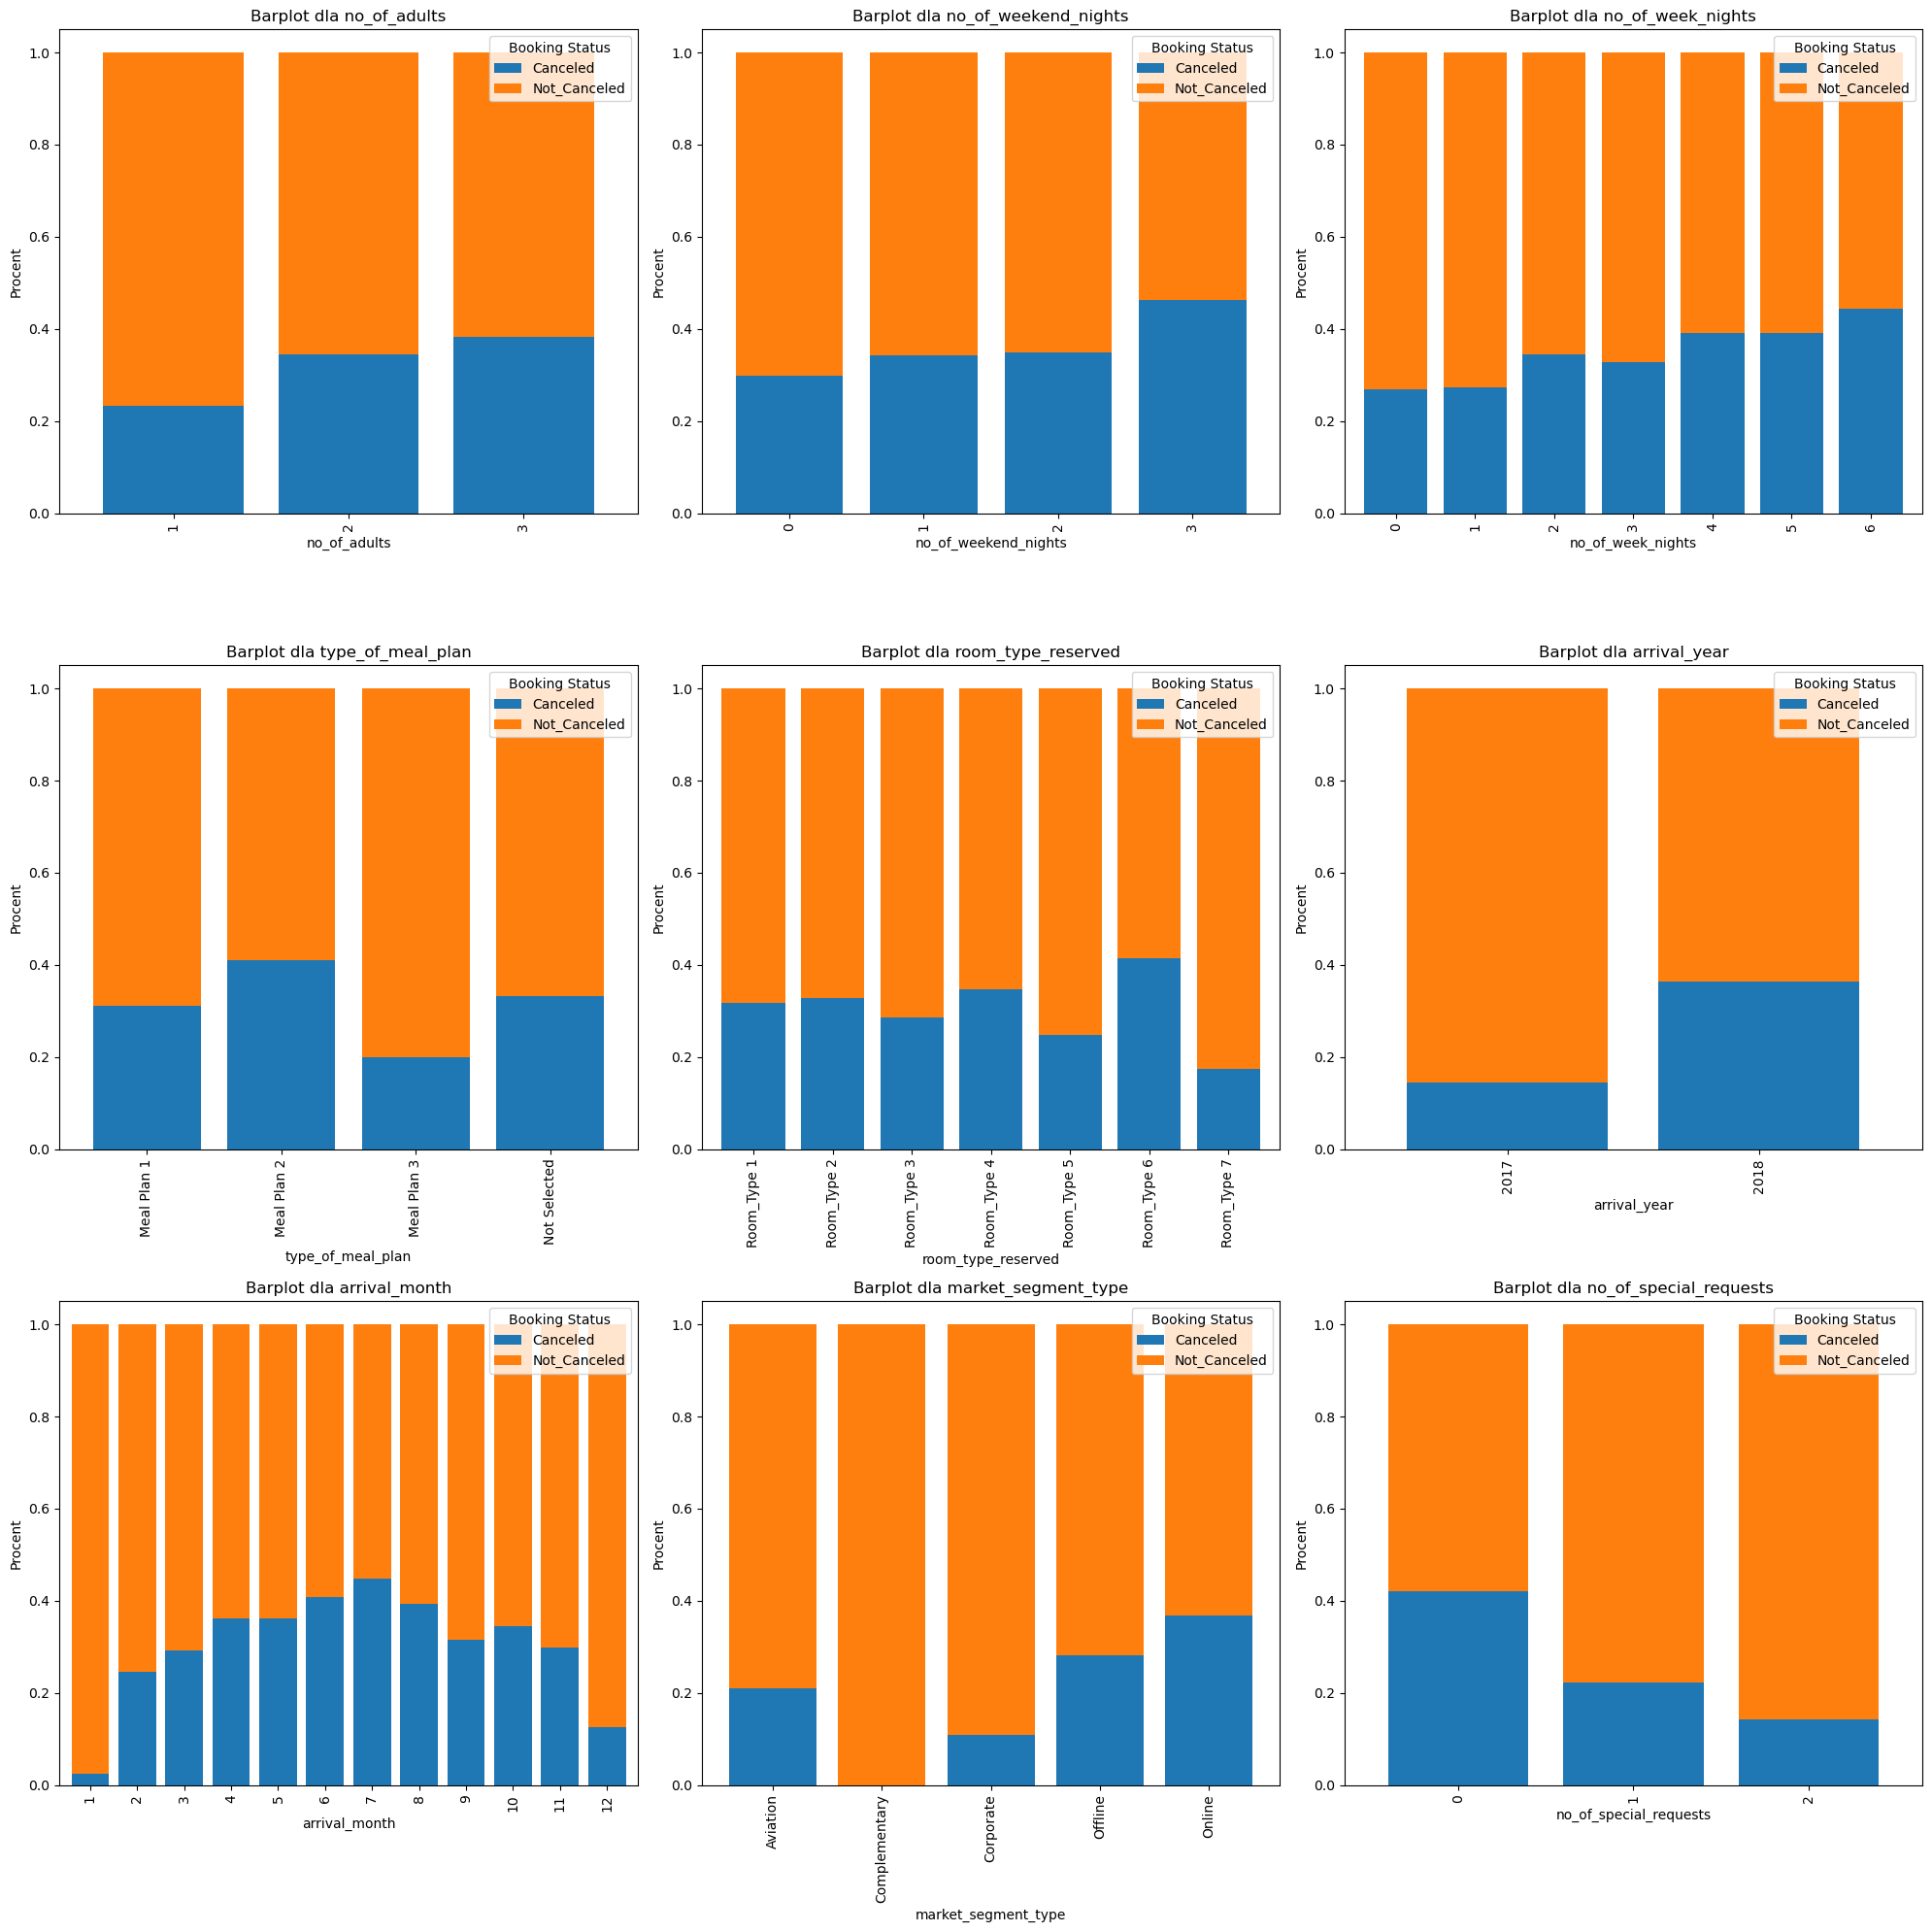

In [333]:
# Zakładając, że df to nasza ramka danych, sprawdźmy typy zmiennych
object_columns = df.drop(["lead_time", "avg_price_per_room", "booking_status"], axis=1)

fig, ax = plt.subplots(3,3, figsize=(20, 20))

# Spłaszczenie osi dla łatwiejszego indeksowania
ax = ax.flatten()

# Tworzenie wykresów
for i, column in enumerate(object_columns):
     df_grouped = df.groupby([column, 'booking_status']).size().unstack().fillna(0)
     df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0)  # Normalizacja do procentów
     df_grouped.plot(kind='bar', stacked=True, ax=ax[i], width=0.8)  # Rysowanie na odpowiedniej osi
     ax[i].set_title(f'Barplot dla {column}')
     ax[i].set_xlabel(column)
     ax[i].set_ylabel('Procent')
     ax[i].legend(title='Booking Status')


plt.tight_layout()
plt.show()


##### Wykresy dla pozostałych zmiennych (rozkłady gęstości)

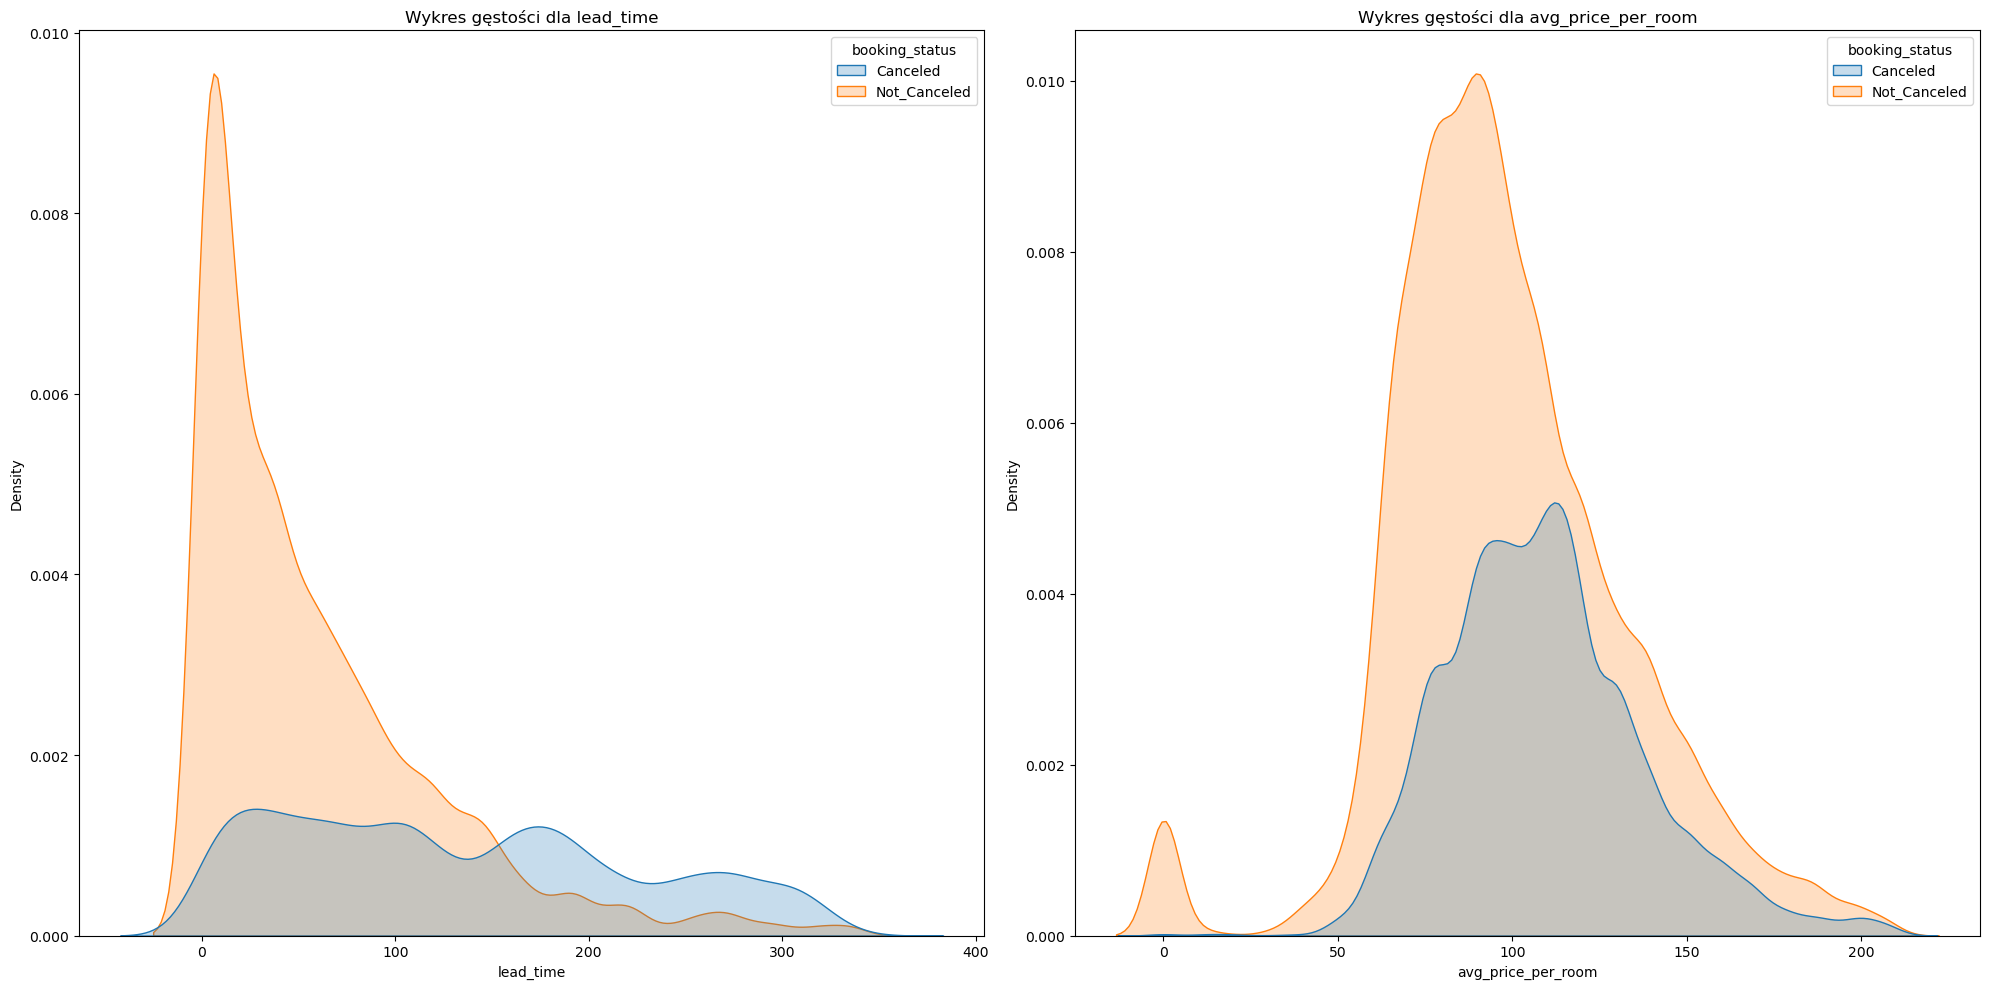

In [349]:
numeric_columns = df.loc[:, ["lead_time", "avg_price_per_room"]].columns
fig, ax = plt.subplots(1,2, figsize=(20, 10))
ax = ax.flatten()

# Tworzenie wykresów
for i, column in enumerate(numeric_columns):
    sns.kdeplot(data=df, x=column, hue='booking_status', fill=True, ax=ax[i])
    ax[i].set_title(f'Wykres gęstości dla {column}')
    

plt.tight_layout()
plt.show()

#### Przeprowadzamy test niezależności chi-kwadrat pomiędzy zmiennymi objaśniającymi a zmienną objaśnianą. Dla zmiennej *lead_time* oraz *avg_price_per_room* tworzymy ręcznie 15 przedziałów.

In [437]:
from scipy.stats import chi2_contingency

df_pvals = pd.DataFrame(columns=["Variable", "P-value"])
for column in object_columns:
    data_crosstab = np.array(pd.crosstab(df['booking_status'],
                                         df[column]))
    
    res = chi2_contingency(data_crosstab)
    df_pvals.loc[len(df_pvals)] = [column, res.pvalue]

for column in ["lead_time", "avg_price_per_room"]:
    # Dane wejściowe
    x1 = df[df["booking_status"] == "Canceled"][column]
    x2 = df[df["booking_status"] == "Not_Canceled"][column]
    bins = np.linspace(0, max(x1.max(), x2.max()), 15)  # Przedziały
    hist1, _ = np.histogram(x1, bins=bins)
    hist2, _ = np.histogram(x2, bins=bins)
    res = chi2_contingency(data_crosstab)
    df_pvals.loc[len(df_pvals)] = [column, res.pvalue]
    
df_pvals

,Variable,P-value
0,no_of_adults,2.158455e-81
1,no_of_weekend_nights,1.225318e-20
2,no_of_week_nights,1.917269e-54
3,type_of_meal_plan,7.609300e-26
4,room_type_reserved,6.537960e-12
5,arrival_year,1.185223e-246
6,arrival_month,1.140307e-293
7,market_segment_type,2.395404e-188
8,no_of_special_requests,0.000000e+00
9,lead_time,0.000000e+00


### Wniosek: Hipoteza zerowa o tym, że zmienne są niezależne nie zachowały się. P-value we wszystkich przypadkach wyniosła poniżej 0.05. Zatem pozostawiamy wszystkie zmienne.

# Modele Machine Learningowe

